In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [101]:
path = '../input/hexagon/different_layer_time/'
layer_time = [2,3,4]

In [102]:
def read_profile(file):
    df = pd.read_csv(file)
    df_filtered = df[[df.columns[0], df.columns[-1]]].to_numpy()
    df_filtered[:, 0] = df_filtered[:, 0] - df_filtered[0, 0]
    x = df_filtered[:,0]
    y = df_filtered[:,1]
    return x[:100], y[:100]

In [103]:
x_2, y_2 = read_profile(path + '2min_corner.csv')
x_3, y_3 = read_profile(path + '3min_corner.csv')
x_4, y_4 = read_profile(path + '4min_corner.csv')

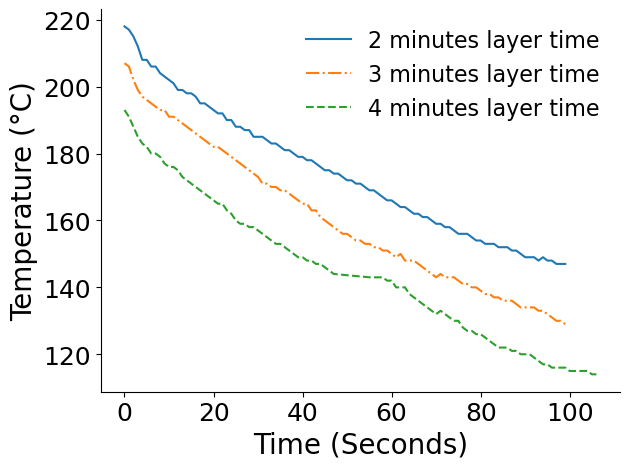

In [105]:
plt.plot(x_2, y_2, linestyle='solid', label='2 minutes layer time')
plt.plot(x_3, y_3, linestyle='dashdot', label ='3 minutes layer time')
plt.plot(x_4, y_4, linestyle='dashed', label='4 minutes layer time')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(frameon=False, fontsize=16)
plt.xlabel("Time (Seconds)", fontsize=20)
plt.ylabel("Temperature (°C)", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig('../paper_plot/different_layertime.png')
plt.show()

In [84]:
def temp(t, b0, b1, T_env, T0):
    T = T_env - (b0/b1) + (T0 - T_env + (b0/b1))*np.exp(b1*(t))
    return T

def regression_for_one_layer(profile):
    reg = LinearRegression()
    T_env = 24

    X = [i - T_env for i in profile]
    X = X[:len(profile) - 1]
    Y = [profile[i + 1] - profile[i] for i in range(len(profile) - 1)]
    X = np.array(X).reshape(-1, 1)
    Y = np.array(Y).reshape(-1, 1)
    reg.fit(X, Y)
    b0 = reg.intercept_[0]
    b1 = reg.coef_[0][0]

    regression_profile = []
    for i in range(200):
        t = temp(i, b0, b1, T_env, profile[0])
        regression_profile.append(t)
    plt.plot(regression_profile)
    plt.plot(profile)
    plt.show()
    return b0, b1, profile[0], regression_profile

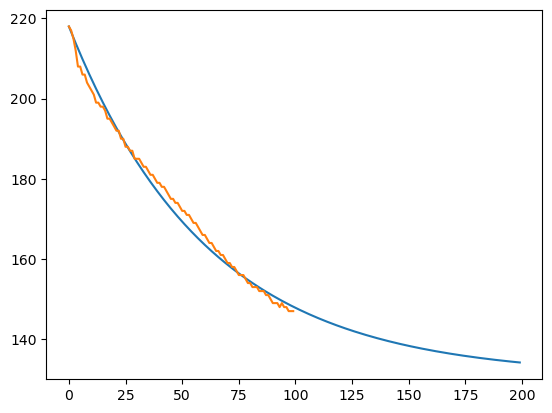

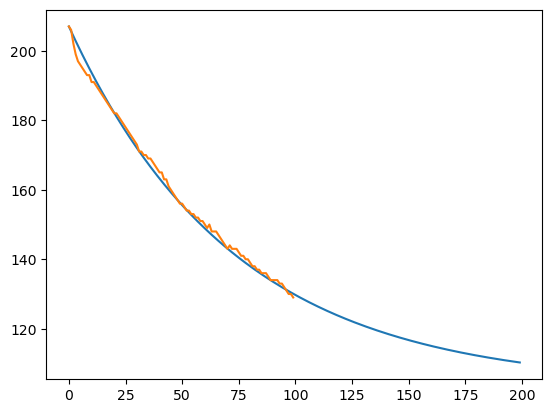

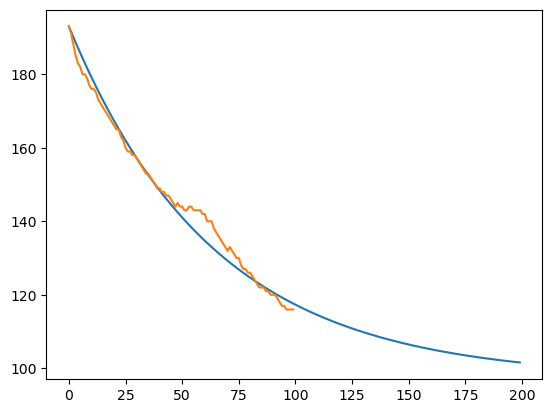

In [85]:
b0_2, b1_2, _, profile_2 = regression_for_one_layer(y_2)
b0_3, b1_3, _, profile_3 = regression_for_one_layer(y_3)
b0_4, b1_4, _, profile_4 = regression_for_one_layer(y_4)

In [86]:
print(b1_2, b1_3, b1_4)
print(b0_2, b0_3, b0_4)

-0.016344712997340555 -0.013765601490729832 -0.015677179316740765
1.745927002094179 1.095922919155634 1.1501985674880686


In [87]:
time_labels = np.array([2, 3, 4])
X_train = np.array([[t, x] for t in time_labels for x in range(100)])
Y_train = np.concatenate([y_2, y_3, y_4])

In [88]:
Y_train.shape

(300,)

In [89]:
kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# 训练模型
gp.fit(X_train, Y_train)

# 预测任意时间点的温度曲线
def predict_temperature_curve(gp, target_time):
    X_test = np.array([[target_time, x] for x in range(100)])  # 构建目标时间下每个位置的输入
    y_pred, sigma = gp.predict(X_test, return_std=True)  # 返回预测值和标准差
    return y_pred, sigma


/Users/xiehaoyang/anaconda3/envs/ICRA/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


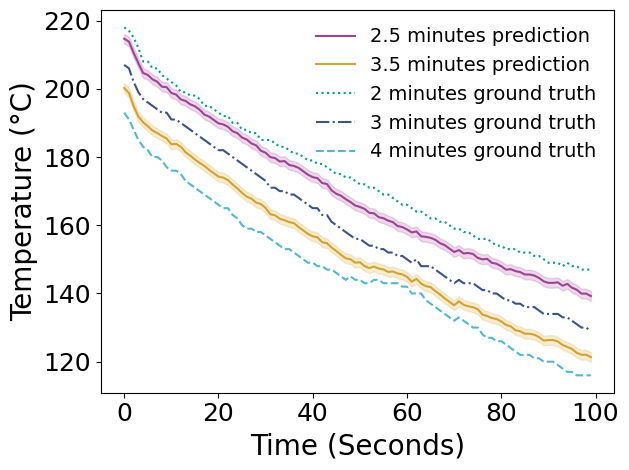

In [97]:
target_time_1 = 2.5
y_pred_1, sigma_1 = predict_temperature_curve(gp, target_time_1)
target_time_2 = 3.5
y_pred_2, sigma_2 = predict_temperature_curve(gp, target_time_2)

plt.plot(range(100), y_pred_1, color='#A04294', label=f'{2.5} minutes prediction')
plt.fill_between(range(100), y_pred_1 - sigma_1, y_pred_1 + sigma_1, alpha=0.2, color='#A04294')
plt.plot(range(100), y_pred_2, color='#D6A228', label=f'{3.5} minutes prediction')
plt.fill_between(range(100), y_pred_2 - sigma_2, y_pred_2 + sigma_2, alpha=0.2, color='#D6A228')
plt.plot(range(100), y_2, linestyle=':', color='#039F89', label='2 minutes ground truth')
plt.plot(range(100), y_3, linestyle='dashdot', color='#3B5387', label='3 minutes ground truth')
plt.plot(range(100), y_4, linestyle='dashed', color='#4EB9D3', label='4 minutes ground truth')
plt.xlabel("Time (Seconds)", fontsize=20)
plt.ylabel("Temperature (°C)", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(frameon=False, fontsize=14)
plt.tight_layout()
plt.savefig('../paper_plot/gp.png')
plt.show()

In [74]:
sigma_1

array([1.41950038, 1.41950038, 1.41950038, 1.41950038, 1.41950038,
       1.41950038, 1.41950038, 1.41950038, 1.41950038, 1.41950038,
       1.41950038, 1.41950038, 1.41950038, 1.41950038, 1.41950038,
       1.41950038, 1.41950038, 1.41950038, 1.41950038, 1.41950038,
       1.41950038, 1.41950038, 1.41950038, 1.41950038, 1.41950038,
       1.41950038, 1.41950038, 1.41950038, 1.41950038, 1.41950038,
       1.41950038, 1.41950038, 1.41950038, 1.41950038, 1.41950038,
       1.41950038, 1.41950038, 1.41950038, 1.41950038, 1.41950038,
       1.41950038, 1.41950038, 1.41950038, 1.41950038, 1.41950038,
       1.41950038, 1.41950038, 1.41950038, 1.41950038, 1.41950038,
       1.41950038, 1.41950038, 1.41950038, 1.41950038, 1.41950038,
       1.41950038, 1.41950038, 1.41950038, 1.41950038, 1.41950038,
       1.41950038, 1.41950038, 1.41950038, 1.41950038, 1.41950038,
       1.41950038, 1.41950038, 1.41950038, 1.41950038, 1.41950038,
       1.41950038, 1.41950038, 1.41950038, 1.41950038, 1.41950

In [75]:
sigma_2

array([1.41950038, 1.41950038, 1.41950038, 1.41950038, 1.41950038,
       1.41950038, 1.41950038, 1.41950038, 1.41950038, 1.41950038,
       1.41950038, 1.41950038, 1.41950038, 1.41950038, 1.41950038,
       1.41950038, 1.41950038, 1.41950038, 1.41950038, 1.41950038,
       1.41950038, 1.41950038, 1.41950038, 1.41950038, 1.41950038,
       1.41950038, 1.41950038, 1.41950038, 1.41950038, 1.41950038,
       1.41950038, 1.41950038, 1.41950038, 1.41950038, 1.41950038,
       1.41950038, 1.41950038, 1.41950038, 1.41950038, 1.41950038,
       1.41950038, 1.41950038, 1.41950038, 1.41950038, 1.41950038,
       1.41950038, 1.41950038, 1.41950038, 1.41950038, 1.41950038,
       1.41950038, 1.41950038, 1.41950038, 1.41950038, 1.41950038,
       1.41950038, 1.41950038, 1.41950038, 1.41950038, 1.41950038,
       1.41950038, 1.41950038, 1.41950038, 1.41950038, 1.41950038,
       1.41950038, 1.41950038, 1.41950038, 1.41950038, 1.41950038,
       1.41950038, 1.41950038, 1.41950038, 1.41950038, 1.41950

In [68]:
def get_sigma(time):
    _, sigma = predict_temperature_curve(gp, time)
    return np.mean(sigma)

In [69]:
sigma_list = []
for time in time_range:
    sigma_list.append(get_sigma(time))

In [70]:
sigma_list

[0.5923204744399543,
 1.024723999945076,
 1.3007672079882826,
 1.428333380243967,
 1.4195003772467976,
 1.2902651786138157,
 1.0601317598208122,
 0.7515747363325435,
 0.3893964807453644,
 0.3893964807452797,
 0.7515747363325893,
 1.0601317598208029,
 1.2902651786137362,
 1.4195003772467922,
 1.4283333802439586,
 1.3007672079883,
 1.0247239999450968,
 0.5923204744400233]